In [1]:
# import packages
import os
import sys
import datetime
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from osgeo import gdal, ogr

%matplotlib inline
tf.enable_eager_execution()
tfe = tf.contrib.eager

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("GPU available:", tf.test.is_gpu_available())

TensorFlow version: 1.12.0
Eager execution: True
GPU available: False


In [2]:
# settings
area = "all4hamburg"

os.chdir("/home/gekkoskill")
outDir = os.path.join(os.getcwd(), "output")
patTr = os.path.join(outDir, "patches", area, "train")
patTe = os.path.join(outDir, "patches", area, "test")
ckptDir = os.path.join(outDir, "checkpts", area)
ckptPrefix = os.path.join(ckptDir, "ckpt")
logDir = os.path.join(outDir, "logs", area)

cities_train = ["berlin", "frankfurt", "cologne"]
cities_test = ["hamburg"]

shpAttName = "Name"

sampleDistance = 2
maxPatchesPerClass_train = 12500
maxPatchesPerClass_valid = 1000
patchSize = 32

numBands = 10
epochs = 200
batchSize = 650
learningRate = 0.001
dropoutRate = 0.25

if not os.path.exists(patTr):
    os.makedirs(patTr)
    os.makedirs(patTe)
if not os.path.exists(ckptDir):
    os.makedirs(ckptDir)

In [ ]:
# create vrt 
def createVRT(area):
    outputname = os.path.join(os.getcwd(), "input", area + "_omega.vrt")
    pathy = os.path.join(os.getcwd(), "data", area)

    bands = []
    for file in os.listdir(pathy):
        bands.append(os.path.join(pathy, file))
    bands.sort()

    gdal.BuildVRT(destName = outputname, 
                  srcDSOrSrcDSTab = bands, 
                  separate = True
                 ).FlushCache()

def reprojectVRT(area, EPSG):
    ds = gdal.Open(os.path.join(os.getcwd(), "input", area + "_omega.vrt"))
    ds = gdal.Translate(os.path.join(os.getcwd(), "input", area + "_omega.vrt")[:-4]+"_reproj.vrt", ds, options = gdal.TranslateOptions(outputSRS=EPSG))
    ds = None

for c in cities_train:
    print(c)
    createVRT(c)
for c in cities_test:
    print(c)
    createVRT(c)
    
reprojectVRT("cologne", "EPSG:32632")
reprojectVRT("rostock", "EPSG:32633")
reprojectVRT("muenster", "EPSG:32632")

In [4]:
# rasterize vector files (e.g., shapefile, kmz, ...)
def rasterizeShapefile(area, trainortest):
    shpPath = os.path.join(os.getcwd(), "input", area + "_" + trainortest + ".kmz")
    img = gdal.Open(os.path.join(os.getcwd(), "input", area + "_omega.vrt"))
    shp = ogr.Open(shpPath)
    out = gdal.GetDriverByName('GTiff')
    out = out.Create(os.path.join(outDir, os.path.basename(shpPath[:-4]) + ".tif"), img.RasterXSize, img.RasterYSize, 1, gdal.GDT_Byte)
    out.SetGeoTransform(img.GetGeoTransform())
    out.SetProjection(img.GetProjectionRef())
    gdal.RasterizeLayer(out, [1], shp.GetLayer(), options=[str("ATTRIBUTE=" + shpAttName)])
    r = None
    
for c in cities_train:
    print(c)
    #rasterizeShapefile(c, "train")
for c in cities_test:
    print(c)
    rasterizeShapefile(c, "test")

berlin
frankfurt
cologne
hamburg


In [5]:
# create image patches
def createPatches(area, trainortest, outPath, training):
    shpPath = os.path.join(os.getcwd(), "input", area + "_" + trainortest + ".kmz")
    img = os.path.join(os.getcwd(), "input", area + "_omega.vrt")
    r = gdal.Open(os.path.join(outDir, os.path.basename(shpPath[:-4]) + ".tif"))
    rData = r.ReadAsArray()
    sampleGrid = np.zeros((rData.shape[0], rData.shape[1]))
    sampleGrid[int(patchSize/2+1):rData.shape[0]-int(patchSize/2+1):sampleDistance, int(patchSize/2+1):rData.shape[1]-int(patchSize/2+1):sampleDistance] = 1
    print("unique values:", np.unique(rData))
    for cla in np.unique(rData):
        if cla > 0:
            xy = np.argwhere(rData == cla)
            xy = xy[np.random.permutation(xy.shape[0])]
            counter = 0
            if training:
                for idx, loc in enumerate(xy):
                    if sampleGrid[loc[0], loc[1]] == 1 and counter < maxPatchesPerClass_train:
                        counter += 1
                        out = os.path.join(outPath, str('{0:02d}').format(cla) + "_" + area + "_" + \
                                           str('{0:0'+str(len(str(maxPatchesPerClass_train)))+'d}').format(counter) + ".vrt")
                        gdal.Translate(out, img, format = 'vrt', srcWin = [loc[1] - patchSize / 2,
                                                                             loc[0] - patchSize / 2,
                                                                             patchSize,
                                                                             patchSize])
            else:
                for idx, loc in enumerate(xy):
                    if counter < maxPatchesPerClass_valid:
                        counter += 1
                        out = os.path.join(outPath, str('{0:02d}').format(cla) + "_" + area + "_" + \
                                           str('{0:0'+str(len(str(maxPatchesPerClass_valid)))+'d}').format(counter) + ".vrt")
                        gdal.Translate(out, img, format = 'vrt', srcWin = [loc[1] - patchSize / 2,
                                                                             loc[0] - patchSize / 2,
                                                                             patchSize,
                                                                             patchSize])
            print("class", str(cla), ":", str(counter))

for c in cities_train:
    print(c)
    #createPatches(c, "train", patTr, True)
for c in cities_test:
    print(c)
    createPatches(c, "test", patTe, False)

berlin
frankfurt
cologne
hamburg
unique values: [ 0  2  4  5  6  8  9 10 11 12 14 15 16 17]
class 2 : 1000
class 4 : 149
class 5 : 1000
class 6 : 1000
class 8 : 1000
class 9 : 1000
class 10 : 1000
class 11 : 1000
class 12 : 1000
class 14 : 1000
class 15 : 1000
class 16 : 1000
class 17 : 1000


In [6]:
# load image patches
def loadPatches(patchFolder):
    patches, labels = [], []
    for i in os.listdir(patchFolder):
        x = gdal.Open(os.path.join(patchFolder, i)).ReadAsArray()
        x = np.moveaxis(x, 0, -1)
        if not np.isnan(x).any():
            patches.append(x)
            labels.append(int(i.split("_")[0]))
    labels = np.array(labels, dtype=np.int32)
    labs = np.zeros(labels.shape, dtype=np.int32)
    allclasses = [1,  2,  4,  5,  6,  8,  9, 10, 11, 12, 14, 15, 16, 17]
    for idx, c in enumerate(allclasses):
        labs[labels == c] = idx
    return np.array(patches, dtype=np.float32), tf.one_hot(labs, len(allclasses)).numpy()

def calcNormStats(patches):
    means, stds, mins, maxs = [], [], [], []
    for i in range(patches.shape[3]):
        means.append(np.nanmean(patches[:, :, :, i]))
        stds.append(np.nanstd(patches[:, :, :, i]))
    np.savetxt(os.path.join(outDir, area + "_means.txt"), means)
    np.savetxt(os.path.join(outDir, area + "_stds.txt"), stds)
    return means, stds

def showCount(labels):
    imp = []
    for idx, c in enumerate(range(labels.shape[1])):
        imp.append(int(np.sum(labels[:, c])))
        print("Class:", idx, "-", int(np.sum(labels[:, c])))
    weights = tf.nn.softmax(1 - (np.array(imp) / np.sum(np.array(imp)))).numpy()
    return tf.constant(list(weights), dtype=tf.float32)

def normPatches(patches, means, stds):
    for i in range(patches.shape[0]):
        patch = patches[i, :, :, :]
        for j in range(patch.shape[2]):
            patch[:, :, j] = (patch[:, :, j] - means[j]) / stds[j]
        patches[i, :, :, :] = patch
    return patches

# import and normalize train/test data
X_train, y_train = loadPatches(patTr)
X_test, y_test = loadPatches(patTe)
print("finished loading")
means, stds = calcNormStats(X_train)
print("finished calculating")
classweights = showCount(y_train)
print(classweights)
showCount(y_test)
X_train = normPatches(X_train, means, stds)
X_test = normPatches(X_test, means, stds)
print("finished normalizing")

finished loading
finished calculating
Class: 0 - 476
Class: 1 - 11891
Class: 2 - 11633
Class: 3 - 32848
Class: 4 - 29085
Class: 5 - 34434
Class: 6 - 10666
Class: 7 - 10473
Class: 8 - 22850
Class: 9 - 7968
Class: 10 - 21490
Class: 11 - 13894
Class: 12 - 7546
Class: 13 - 13276
tf.Tensor(
[0.0764873  0.07276063 0.07284282 0.06638503 0.06748718 0.06592591
 0.0731517  0.0732135  0.06935378 0.07402044 0.06976774 0.0721257
 0.07415725 0.07232101], shape=(14,), dtype=float32)
Class: 0 - 0
Class: 1 - 1000
Class: 2 - 149
Class: 3 - 1000
Class: 4 - 1000
Class: 5 - 1000
Class: 6 - 1000
Class: 7 - 1000
Class: 8 - 1000
Class: 9 - 1000
Class: 10 - 1000
Class: 11 - 1000
Class: 12 - 1000
Class: 13 - 1000
finished normalizing


In [7]:
# create datasets for iterators
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000000).batch(batchSize)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(10000000).batch(batchSize)

In [8]:
class CNN(tf.keras.Model):
    
    def __init__(self, numClasses, dropoutRate, ckptDir, logDir):
        super(CNN, self).__init__()
        self.ckptDir = ckptDir
        self.logDir = logDir
        
        self.conv1 = tf.layers.Conv2D(filters=16, kernel_size=3, padding="same", activation=None, kernel_initializer=tf.random_normal_initializer(), bias_initializer=tf.random_normal_initializer(), name="conv1")
        self.batch1 = tf.layers.BatchNormalization(beta_initializer=tf.random_normal_initializer(), gamma_initializer=tf.random_normal_initializer(), name="batch1")
        self.maxpool1 = tf.layers.MaxPooling2D(pool_size=[2, 2], strides=2, padding="same", name="maxpool1")
        self.conv2 = tf.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation=None, kernel_initializer=tf.random_normal_initializer(), bias_initializer=tf.random_normal_initializer(), name="conv2")
        self.batch2 = tf.layers.BatchNormalization(beta_initializer=tf.random_normal_initializer(), gamma_initializer=tf.random_normal_initializer(), name="batch2")
        self.maxpool2 = tf.layers.MaxPooling2D(pool_size=[2, 2], strides=2, padding="same", name="maxpool2")
        self.conv3 = tf.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation=None, kernel_initializer=tf.random_normal_initializer(), bias_initializer=tf.random_normal_initializer(), name="conv3")
        self.batch3 = tf.layers.BatchNormalization(beta_initializer=tf.random_normal_initializer(), gamma_initializer=tf.random_normal_initializer(), name="batch3")
        self.maxpool3 = tf.layers.MaxPooling2D(pool_size=[2, 2], strides=2, padding="same", name="maxpool3")
        self.conv4 = tf.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation=None, kernel_initializer=tf.random_normal_initializer(), bias_initializer=tf.random_normal_initializer(), name="conv4")
        self.batch4 = tf.layers.BatchNormalization(beta_initializer=tf.random_normal_initializer(), gamma_initializer=tf.random_normal_initializer(), name="batch4")
        self.maxpool4 = tf.layers.MaxPooling2D(pool_size=[2, 2], strides=2, padding="same", name="maxpool4")
        self.dense1 = tf.layers.Dense(units=256, activation=None, kernel_initializer=tf.random_normal_initializer(), bias_initializer=tf.random_normal_initializer(), name="dense1")
        self.drop1 = tf.layers.Dropout(rate=dropoutRate, name="drop1")
        self.dense2 = tf.layers.Dense(units=numClasses, activation=None, kernel_initializer=tf.random_normal_initializer(), bias_initializer=tf.random_normal_initializer(), name="dense2")

    def predict(self, images, phaseTrain):
        conv1 = self.conv1(images)
        batch1 = self.batch1(conv1, training=phaseTrain)
        relu1 = tf.nn.relu(batch1)
        pool1 = self.maxpool1(relu1)
        conv2 = self.conv2(pool1)
        batch2 = self.batch2(conv2, training=phaseTrain)
        relu2 = tf.nn.relu(batch2)
        pool2 = self.maxpool2(relu2)
        conv3 = self.conv3(pool2)
        batch3 = self.batch3(conv3, training=phaseTrain)
        relu3 = tf.nn.relu(batch3)
        pool3 = self.maxpool3(relu3)
        conv4 = self.conv4(pool3)
        batch4 = self.batch4(conv4, training=phaseTrain)
        relu4 = tf.nn.relu(batch4)
        pool4 = self.maxpool4(relu4)
        flat1 = tf.layers.flatten(pool4)
        dense1 = self.dense1(flat1)
        relu5 = tf.nn.relu(dense1)
        drop1 = self.drop1(relu5, training=phaseTrain)
        dense2 = self.dense2(drop1)
        return dense2

    def augment(self, images, labels):
        X, y = [], []
        labels = labels.numpy()
        images = images.numpy()
        for idx, image in enumerate(images):
            for r in range(0, 4):
                # rotate
                imageRotated = np.rot90(image, k=r, axes=(0, 1))
                X.append(imageRotated)
                y.append(labels[idx, :])
                 # flip rotated 
                imageRotated = np.fliplr(imageRotated)
                X.append(imageRotated)
                y.append(labels[idx, :])
        return tf.convert_to_tensor(np.array(X, np.float32)), tf.convert_to_tensor(np.array(y, np.float32))
        
    def train(self, trainingData, testData, optimizer, epochs, global_step):  
        
        time = datetime.datetime.now().strftime("%Y%m%d_%H_%M")
        train_summary_writer = tf.contrib.summary.create_file_writer(os.path.join(self.logDir, "train", time), name="train")
        test_summary_writer = tf.contrib.summary.create_file_writer(os.path.join(self.logDir, "test", time), name="test")
        
        for i in range(epochs):
            with train_summary_writer.as_default():
                avg_loss_tr = tfe.metrics.Mean("train_loss", dtype=tf.float32)
                accuracy_tr = tfe.metrics.Accuracy("train_accuracy", dtype=tf.float32)
                for images, labels in tfe.Iterator(trainingData):
                    images, labels = self.augment(images, labels)
                    with tfe.GradientTape() as tape:
                        logits = self.predict(images, True)
                        loss = tf.losses.softmax_cross_entropy(logits=logits, onehot_labels=labels, weights=tf.reduce_sum(classweights * labels, axis=1))
                    grads = tape.gradient(loss, self.variables)
                    optimizer.apply_gradients(zip(grads, self.variables), global_step=global_step)
                    avg_loss_tr(loss)
                    accuracy_tr(tf.argmax(tf.nn.softmax(logits), axis=1, output_type=tf.int64), tf.argmax(tf.cast(labels, tf.int64), axis=1, output_type=tf.int64))
                trainAcc, trainLoss = 100 * accuracy_tr.result(), avg_loss_tr.result()
                with tf.contrib.summary.always_record_summaries():
                    tf.contrib.summary.image("train_images", images[:16, :, :, :3], max_images=12) 
                    tf.contrib.summary.scalar("train_loss", avg_loss_tr.result())
                    tf.contrib.summary.scalar("train_accuracy", accuracy_tr.result())
                        
            with test_summary_writer.as_default():   
                avg_loss_te = tfe.metrics.Mean("test_loss", dtype=tf.float32)
                accuracy_te = tfe.metrics.Accuracy("test_accuracy", dtype=tf.float32)
                for images, labels in tfe.Iterator(testData):
                    logits = self.predict(images, False)
                    avg_loss_te(tf.losses.softmax_cross_entropy(logits=logits, onehot_labels=labels))
                    accuracy_te(tf.argmax(tf.nn.softmax(logits), axis=1, output_type=tf.int64), tf.argmax(tf.cast(labels, tf.int64), axis=1, output_type=tf.int64))
                testAcc, testLoss = 100 * accuracy_te.result(), avg_loss_te.result()
                with tf.contrib.summary.always_record_summaries():
                    tf.contrib.summary.scalar("test_loss", avg_loss_te.result())
                    tf.contrib.summary.scalar("test_accuracy", accuracy_te.result())
                        
            print(str("{0:0"+str(len(str(epochs)))+"d}").format(i+1) + "/" + str(epochs) + "   %.2f   %.2f   %.5f   %.5f" % (trainAcc.numpy(), testAcc.numpy(), trainLoss.numpy(), testLoss.numpy()))
                
            if i % 10 == 0:
                checkpoint.save(file_prefix=ckptPrefix)

In [9]:
# initialize and load checkpoint
model = CNN(y_train.shape[1], dropoutRate, ckptDir, logDir)
optimizer = tf.train.AdamOptimizer(learning_rate=learningRate)
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
global_step = tf.train.get_or_create_global_step().assign(0)
checkpoint.restore(tf.train.latest_checkpoint(ckptDir))

In [10]:
# train model
model.train(train_data, test_data, optimizer, epochs, global_step)

001/200   27.95   26.26   4.79881   5.26199
002/200   27.15   32.38   0.21776   2.38467
003/200   30.95   36.45   0.16434   1.92851
004/200   34.75   39.42   0.14454   1.79084
005/200   36.79   43.30   0.13584   1.69784
006/200   38.98   44.46   0.12976   1.64461
007/200   42.16   46.34   0.12475   1.59103
008/200   45.19   51.77   0.11921   1.52991
009/200   48.14   53.11   0.11195   1.52079
010/200   50.67   58.43   0.10549   1.34462
011/200   52.69   60.81   0.10088   1.30041
012/200   54.60   61.67   0.09699   1.26053
013/200   56.15   62.89   0.09333   1.20926
014/200   57.24   65.74   0.09042   1.23795
015/200   58.72   65.70   0.08742   1.21578
016/200   60.11   65.40   0.08411   1.28168
017/200   61.69   66.01   0.08024   1.26951
018/200   62.99   66.27   0.07696   1.37906
019/200   64.58   68.36   0.07359   1.20955
020/200   66.25   66.91   0.07039   1.28762
021/200   67.78   69.08   0.06722   1.35144
022/200   69.00   70.02   0.06469   1.12732
023/200   70.00   71.69   0.0625

KeyboardInterrupt: 

In [11]:
checkpoint.save(file_prefix=ckptPrefix)

'/home/gekkoskill/output/checkpts/all4hamburg/ckpt-8'

In [12]:
# image classification
def imageClassification(myarea):
    imgDataset = gdal.Open(os.path.join(os.getcwd(), "input", myarea + "_omega.vrt"))
    imgData = imgDataset.ReadAsArray().astype(np.float32)

    for i in range(len(means)):
        imgData[i, :, :] = (imgData[i, :, :] - means[i]) / stds[i]

    imgData[np.isnan(imgData)] = 0
        
    classMap = np.zeros((imgData.shape[1], imgData.shape[2]))

    for x in range(0, imgData.shape[1]-patchSize):
        Xpatches = []
        for y in range(0, imgData.shape[2]-patchSize):
            Xpatch = imgData[:, x:(x+patchSize), y:(y+patchSize)]
            Xpatch = np.moveaxis(Xpatch, 0, -1)
            Xpatches.append(Xpatch)
        Xpatches = np.array(Xpatches, dtype=np.float32)
        pred = model.predict(Xpatches, False)
        classMap[x+int(patchSize/2), int(patchSize/2):int(patchSize/2)+pred.shape[0]] = np.argmax(tf.nn.softmax(pred), 1)
        sys.stdout.write('\rProgress ' + str("{0:.2f}".format(round(x / (imgData.shape[1]-patchSize)*100, 2))) + "%")
    print(myarea, np.unique(classMap))

    # export
    driver = gdal.GetDriverByName('GTiff')
    df = driver.Create(os.path.join(outDir, myarea + "_classification_" + area + ".tif"), imgDataset.RasterXSize, imgDataset.RasterYSize, 1, gdal.GDT_Byte)
    df.SetGeoTransform(imgDataset.GetGeoTransform())
    df.SetProjection(imgDataset.GetProjectionRef())
    df.GetRasterBand(1).WriteArray(classMap)
    df.FlushCache()
    df = None
    
    return classMap

CMmuenster = imageClassification("hamburg")

Progress 99.97%hamburg [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


In [13]:
classes = np.array(("1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A", "B", "C", "D", "E", "F", "G"))
colors = np.array(("#8c0000", # 1
                       "#d00000", # 2
                       "#ff0000", # 3
                       "#bf4d00", # 4
                       "#fe6500", # 5
                       "#ff9955", # 6 
                       "#f9ee05", # 7
                       "#bcbcbc", # 8
                       "#fecca9", # 9
                       "#545454", # 10
                       "#006a00", # A
                       "#00aa00", # B
                       "#638425", # C
                       "#b9db79", # D
                       "#000000", # E
                       "#fbf6ae", # F
                       "#6a6aff"))# G

classes = classes[[0, 1, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16]]
colors = colors[[0, 1, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16]]

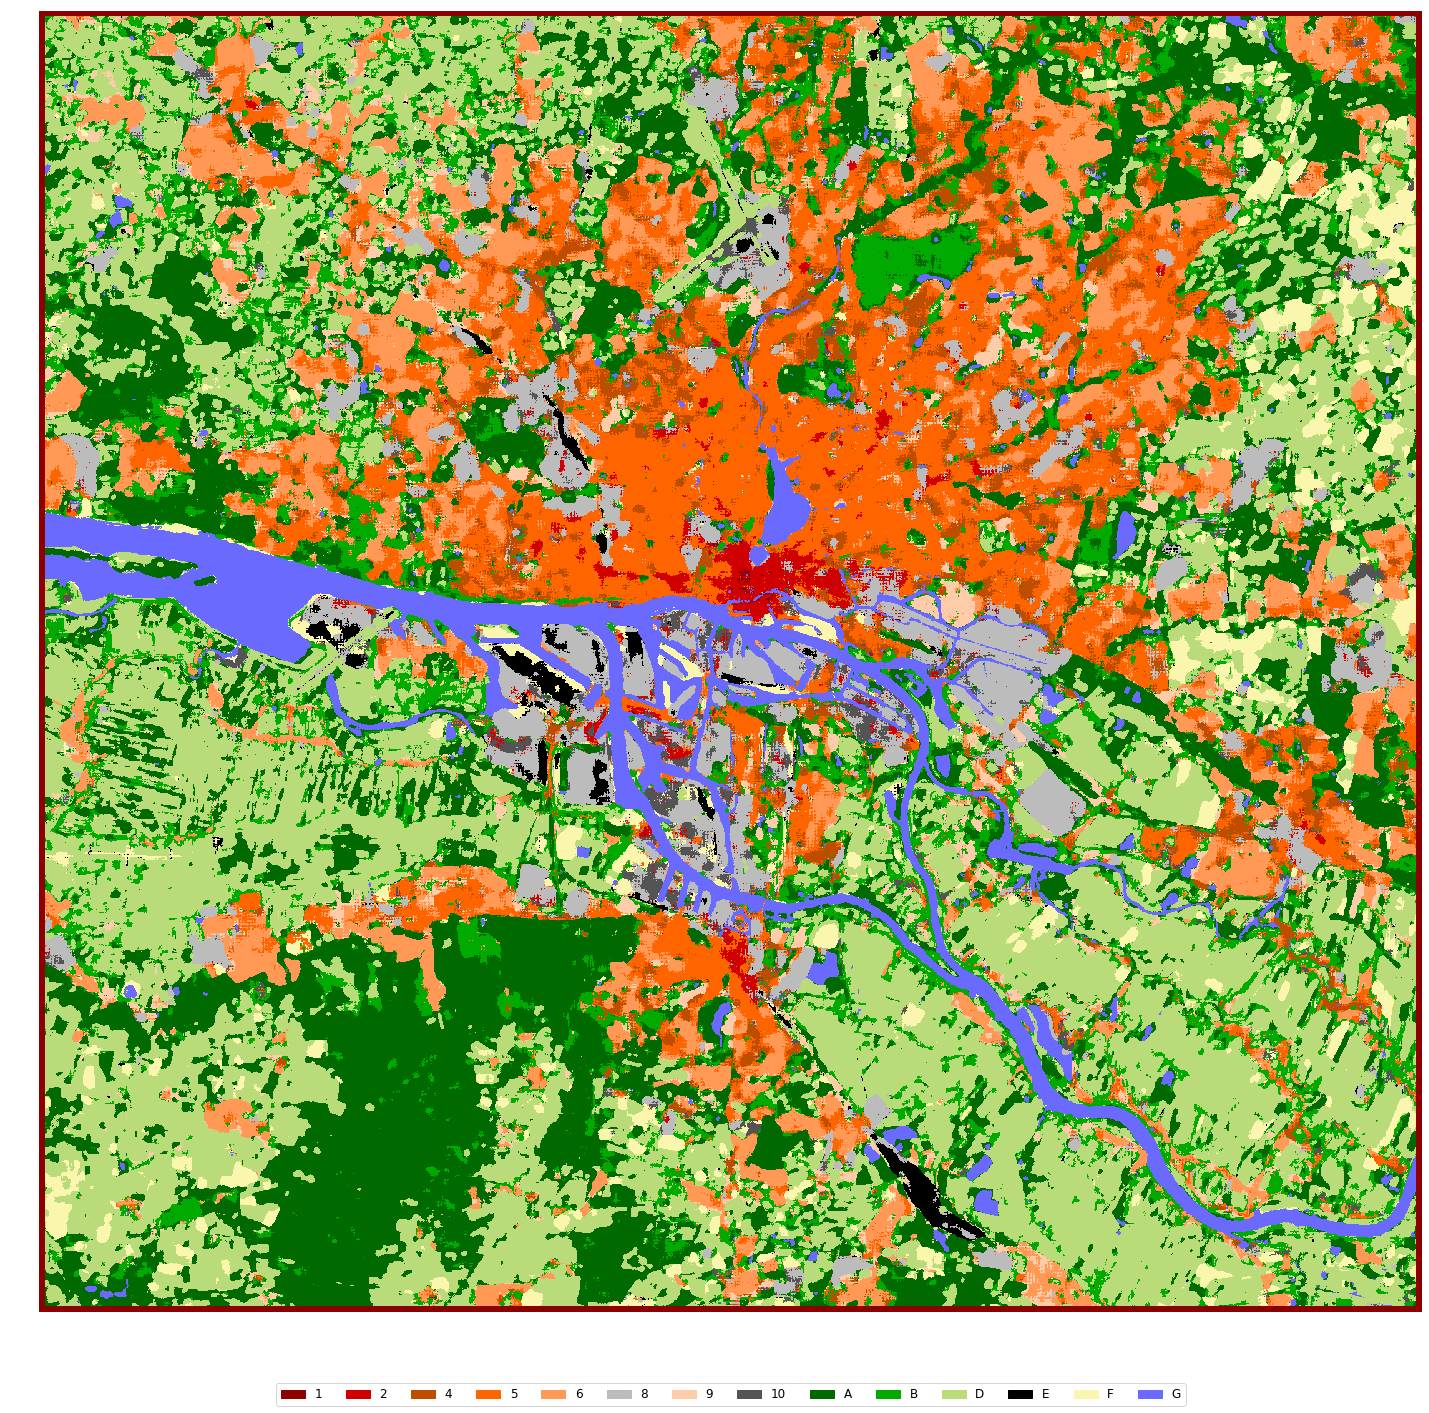

In [15]:
import matplotlib.patches as mpatches

def plotimage(myarea):
    classMap = gdal.Open(os.path.join(outDir, myarea + "_classification_" + area + ".tif")).ReadAsArray()

    plt.figure(figsize=(20, 20))
    plt.imshow(classMap, cmap = plt.matplotlib.colors.ListedColormap(colors))
    patches = [mpatches.Patch(color=colors[i], label=classes[i]) for i in range(len(classes))]
    plt.legend(handles=patches, loc="upper center", ncol=len(classes), bbox_to_anchor=(0.5, -0.05), prop={"size": 12})
    plt.tight_layout()
    plt.axis("off")
    plt.show()

plotimage("hamburg")

In [16]:
def areaAdjAcc(confmat, numPixels, classNames, resolution):
    maparea = numPixels * resolution ** 2 / 1000000
    conf = 1.96
    A = np.nansum(maparea) 
    W_i = maparea / A
    n_i = np.nansum(confmat, axis=1)
    p = (W_i * confmat.T / n_i).T
    p[np.isnan(p)] = 0
    p_area = np.nansum(p, axis=0) * A
    p_area_CI = conf * A * np.sqrt( np.nansum( ((W_i * p.T - p.T ** 2) / (n_i - 1)).T , axis=0) )
    OA = np.nansum(np.diag(p))
    PA = np.diag(p) / np.nansum(p, axis=0)
    UA = np.diag(p) / np.nansum(p, axis=1)
    OA_CI = conf * np.sqrt(np.nansum(W_i ** 2 * UA * (1 - UA) / (n_i - 1)))
    UA_CI = conf * np.sqrt(UA * (1 - UA) / (n_i - 1))
    N_j = np.array([np.nansum(maparea / n_i * confmat[: , x]) for x in range(len(maparea))])
    tmp = np.array([np.nansum(np.delete(maparea, x) ** 2 * np.delete(confmat[:, x], x) / np.delete(n_i, x) * ( 1 - np.delete(confmat[:, x], x) / np.delete(n_i, x)) / (np.delete(n_i, x) - 1)) for x in range(len(maparea))])
    PA_CI = conf * np.sqrt(1 / N_j ** 2 * (maparea ** 2 * ( 1 - PA ) ** 2 * UA * (1 - UA) / (n_i - 1) + PA ** 2 * tmp))
    OAarray = np.empty(len(maparea)) * np.nan
    OAarray[0] = OA
    OA_CIarray = np.empty(len(maparea)) * np.nan
    OA_CIarray[0] = OA_CI
    results = np.around(np.vstack([p_area, p_area_CI, PA*100, PA_CI*100, UA*100, UA_CI*100, OAarray*100, OA_CIarray*100]).T, 2)
    columnNames = ["km2", "+-", "PA", "+-", "UA", "+-", "OA", "+-"]
    return results

In [17]:
# VALIDATION METHOD 1 (IMAGE COMP)

possClasses = np.array([0, 1, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16])
possClasses += 1
normalMat = np.zeros((len(possClasses), len(possClasses)), dtype = np.int)

for c in cities_test:
    classif = gdal.Open(os.path.join(outDir, c + "_classification_" + area + ".tif")).ReadAsArray()
    classif = classif[16:-16, 16:-16]

    testmap = gdal.Open(os.path.join(outDir, c + "_test.tif")).ReadAsArray()
    testmap = testmap[16:-16, 16:-16]

    testmapX = np.zeros(testmap.shape)
    testmapX[:] = np.nan
    
    for idx, i in enumerate(possClasses):
        testmapX[testmap == i] = idx

    pos = np.argwhere(~np.isnan(testmapX))
    mod = []
    ref = []
    for x, y in pos:
        ref.append(int(testmapX[x, y]))
        mod.append(int(classif[x, y]))

    for i in range(len(ref)):
        normalMat[mod[i], ref[i]] += 1
        
print("Method1", np.sum(np.diag(normalMat) / np.sum(normalMat)) * 100)
np.savetxt(os.path.join(outDir, area+"_test_method1.txt"), normalMat, fmt='%f', delimiter="\t")

Method1 86.19522700303257


In [18]:
classProb = np.zeros(len(classes))

for c in cities_test:
    classif = gdal.Open(os.path.join(outDir, c + "_classification_" + area + ".tif")).ReadAsArray()
    _, counts = np.unique(classif, return_counts=True)
    classProb += counts

gg = areaAdjAcc(normalMat, classProb, classes, 10)

print("Method1olo", gg[0,-2])
np.savetxt(os.path.join(outDir, area+"_test_method1_olo.txt"), gg, fmt='%f', delimiter="\t")

Method1olo 77.55


/home/gekkoskill/miniconda3/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/gekkoskill/miniconda3/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


In [19]:
# VALIDATION METHOD 2 (Model test data)
rangy = np.arange(X_test.shape[0])
splitty = np.array_split(rangy, 10)
mod = []
for idx, s in enumerate(splitty):
    print(idx)
    testy = (np.argmax(tf.nn.softmax(model.predict(X_test[s], False)), 1))
    for t in testy:
        mod.append(t)
mod = np.array(mod).flatten()

ref = tf.argmax(tf.cast(y_test, tf.int64), axis=1, output_type=tf.int64).numpy()

normalMat = np.zeros((14, 14))

for i in range(len(ref)):
    normalMat[mod[i], ref[i]] += 1
    
print("Method2", np.sum(np.diag(normalMat) / np.sum(normalMat)) * 100)
np.savetxt(os.path.join(outDir, area+"_test_method2.txt"), normalMat, fmt='%f', delimiter="\t")

0
1
2
3
4
5
6
7
8
9
Method2 77.83356654868714


In [20]:
classProb = np.zeros(len(classes))

for c in cities_test:
    classif = gdal.Open(os.path.join(outDir, c + "_classification_" + area + ".tif")).ReadAsArray()
    _, counts = np.unique(classif, return_counts=True)
    classProb += counts

gg = areaAdjAcc(normalMat, classProb, classes, 10)
print("Method1olo", gg[0,-2])
np.savetxt(os.path.join(outDir, area+"_test_method2_olo.txt"), gg, fmt='%f', delimiter="\t")

Method1olo 70.24


/home/gekkoskill/miniconda3/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/gekkoskill/miniconda3/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


In [39]:
allclasses = np.array([0, 1, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16])+1
allclasses

array([ 1,  2,  4,  5,  6,  8,  9, 10, 11, 12, 14, 15, 16, 17])

In [46]:
woho = np.array(os.listdir("output/patches/all/test"))
mask = []
for idx, w in enumerate(woho):
    if w.split("_")[1] == "dortmund":
        mask.append(idx)
c = woho[np.array(mask)]

classes = []
for i in c:
    classes.append(i.split("_")[0])
classes = np.array(classes).flatten().astype(np.int)

showme = [np.sum(classes == allclasses[i]) for i in range(len(allclasses))]
showme

[0, 1000, 0, 1000, 1000, 1000, 957, 1000, 1000, 682, 1000, 1000, 1000, 1000]